# **Notebook 01: Core Model Training & Validation (GBR)**
## Objective
- Train a baseline GradientBoostingRegressor (GBR) model to predict the mean demand.
- Validate this model's performance against the 2023 holdout set.
- Compare its technical precision (WAPE) against the client's existing model_actual.
- Save the model artifact (.joblib) and the validation dataset (.csv) for the subsequent notebooks.

## 0. Setup and Imports
Import all required libraries for the analysis.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib 

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Plotting Setup ---
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7)

## 1. Load and Explore Data (EDA)
Load the raw dataset. We perform a minimal EDA here just to confirm the data structure and the "heavy-tailed" hypothesis that justifies the risk analysis in Notebook 02.

In [14]:
# --- 1. Load Data ---
RAW_DATA_PATH = '../data/raw/demanding_forecast.csv'

df = pd.read_csv(RAW_DATA_PATH)

# Convert 'fecha' (date) column to datetime objects
df['fecha'] = pd.to_datetime(df['fecha'])

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80748 entries, 0 to 80747
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   fecha            80748 non-null  datetime64[ns]
 1   prod_id          80748 non-null  int64         
 2   precio_promedio  80748 non-null  float64       
 3   ventas           80748 non-null  float64       
 4   modelo_actual    80748 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 3.1 MB
None


,fecha,prod_id,precio_promedio,ventas,modelo_actual
0,2017-01-01,0,6651.737920,1786.0,1943.551087
1,2017-02-01,0,4919.698602,2194.0,1853.111850
2,2017-03-01,0,3277.484704,1178.0,1659.733052
3,2017-04-01,0,5906.864332,1010.0,1580.492875
4,2017-05-01,0,4662.644018,1327.0,1552.062093


In [15]:
# --- 2. Basic Data Summary ---
num_products = df['prod_id'].nunique()
fecha_min = df['fecha'].min()
fecha_max = df['fecha'].max()

print(f"Unique Products: {num_products}")
print(f"Date Range: {fecha_min.date()} to {fecha_max.date()}")

Unique Products: 1000
Date Range: 2012-01-01 to 2023-12-01


## 1.1. Target Variable Analysis (ventas)
This quick visualization validates our core business problem: the sales distribution is not normal. It is heavily right-skewed, confirming a "heavy-tailed" distribution. This means extreme sales events (both high and low) are common, justifying the need for a separate risk model (which we will investigate in Notebook 02).

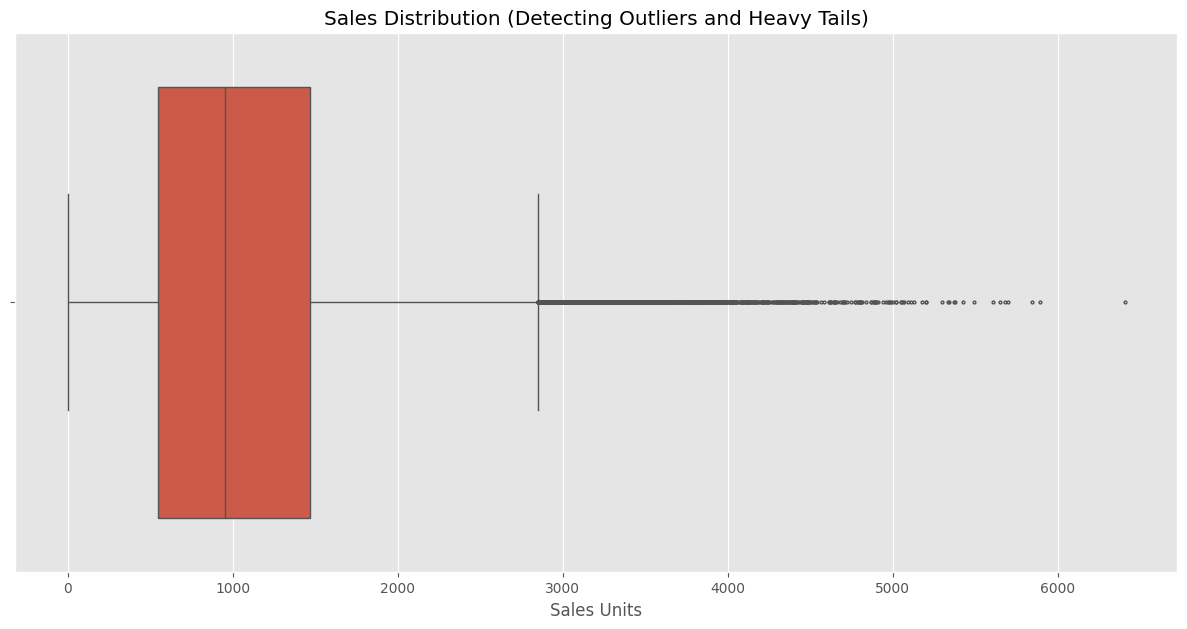

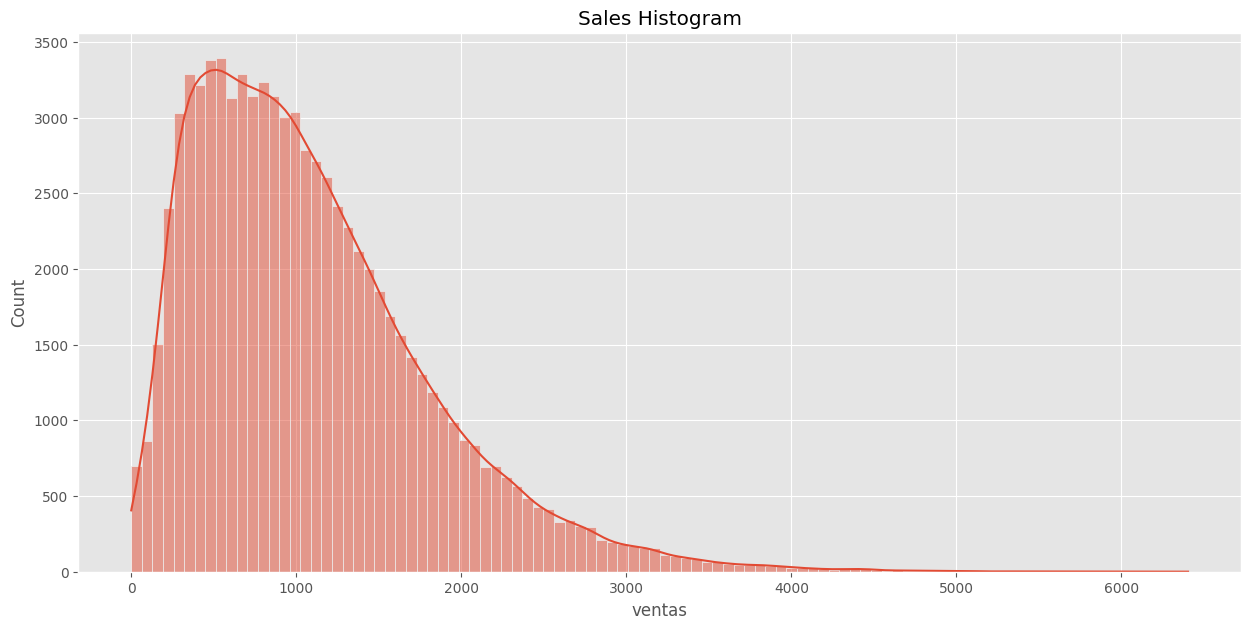

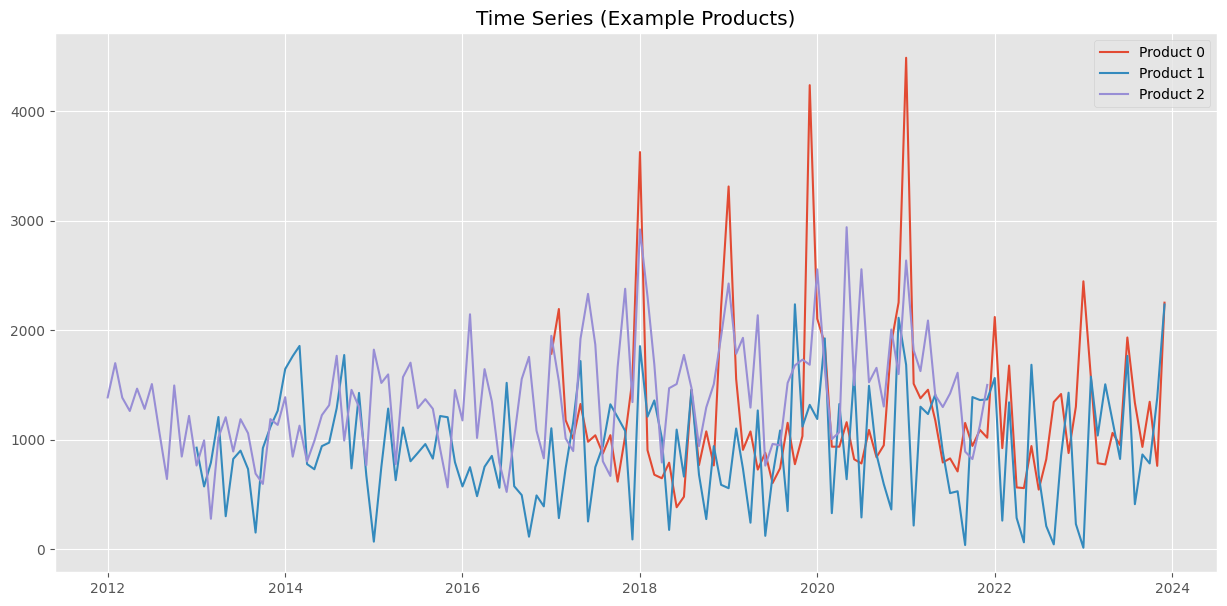

In [16]:
# --- 3. Plot Target Variable Distribution ---
plt.figure(figsize=(15, 7))
sns.boxplot(x=df['ventas'], fliersize=2)
plt.title('Sales Distribution (Detecting Outliers and Heavy Tails)')
plt.xlabel('Sales Units')
plt.show()

plt.figure(figsize=(15, 7))
sns.histplot(df['ventas'], bins=100, kde=True)
plt.title('Sales Histogram')
plt.show()

# --- 4. Time Series Plot for Example Products ---
plt.figure(figsize=(15, 7))
productos_ejemplo = df['prod_id'].unique()[:3]

for pid in productos_ejemplo:
    subset = df[df['prod_id'] == pid]
    plt.plot(subset['fecha'], subset['ventas'], label=f'Product {pid}')

plt.title('Time Series (Example Products)')
plt.legend()
plt.show()

## 2. Feature Engineering
We will create time-series features. Since the client orders one month in advance, we cannot use recent lags (like lag_1) without creating a recursive, and potentially unstable, forecast.

Instead, we will use annual lags (e.g., lag_12, lag_24) as our primary predictors. This is a robust, non-recursive strategy that captures annual seasonality effectively.

In [17]:
def create_features(data):
    """
    Creates time-series features from the input dataframe.
    
    Args:
        data (pd.DataFrame): DataFrame with 'fecha', 'prod_id', 'ventas', 'precio_promedio'.
        
    Returns:
        pd.DataFrame: DataFrame with new features.
    """
    df_feat = data.sort_values(['prod_id', 'fecha']).copy()
    
    # --- Calendar Features ---
    df_feat['year'] = df_feat['fecha'].dt.year
    df_feat['month'] = df_feat['fecha'].dt.month
    
    # --- Lag Features (Annual) ---
    # We use annual lags to capture seasonality without recursive forecasting.
    df_feat['lag_12'] = df_feat.groupby('prod_id')['ventas'].shift(12)
    df_feat['lag_13'] = df_feat.groupby('prod_id')['ventas'].shift(13) # To capture trend
    df_feat['lag_24'] = df_feat.groupby('prod_id')['ventas'].shift(24) # For longer-term patterns
    
    # --- Rolling Window Features ---
    # A rolling mean on the annual lag helps smooth out anomalies from the previous year.
    df_feat['rolling_mean_3_lag12'] = df_feat.groupby('prod_id')['lag_12'].transform(lambda x: x.rolling(3).mean())
    
    # --- Price Features ---
    # We use the price from 12 months ago as a proxy for price-driven demand.
    df_feat['precio_lag_12'] = df_feat.groupby('prod_id')['precio_promedio'].shift(12)
    
    return df_feat

# Apply feature engineering
df_model = create_features(df)

# Drop rows with NaNs created by lags
df_model = df_model.dropna()

print("DataFrame with new features:")
print(df_model.shape)
df_model.head()

DataFrame with new features:
(57420, 12)


,fecha,prod_id,precio_promedio,ventas,modelo_actual,year,month,lag_12,lag_13,lag_24,rolling_mean_3_lag12,precio_lag_12
24,2019-01-01,0,3980.085684,3313.0,1930.239304,2019,1,3627.0,1553.0,1786.0,2070.666667,4475.635674
25,2019-02-01,0,6856.321659,1556.0,2144.931702,2019,2,905.0,3627.0,2194.0,2028.333333,4602.115488
26,2019-03-01,0,3854.781647,908.0,2169.396168,2019,3,681.0,905.0,1178.0,1737.666667,6828.685696
27,2019-04-01,0,3186.701689,1076.0,1618.910678,2019,4,649.0,681.0,1010.0,745.000000,5893.689061
28,2019-05-01,0,3400.851828,728.0,1053.189933,2019,5,791.0,649.0,1327.0,707.000000,5684.850661


## 3. Model Training & Validation Split
We will split our data by time:

- Training Set: All data up to December 31, 2022.

- Validation Set: All data from 2023.

This "holdout" set mimics the real-world scenario of predicting a future year.

In [18]:
# Define feature set and target
TARGET_VARIABLE = 'ventas'
FEATURES = [
    'month', 'year', 'prod_id', 
    'lag_12', 'lag_13', 'lag_24', 
    'rolling_mean_3_lag12', 'precio_lag_12'
]

# Split data into Train (<= 2022) and Validation (== 2023)
train = df_model[df_model['year'] < 2023].copy()
val = df_model[df_model['year'] == 2023].copy()

print(f"Training rows: {len(train)}")
print(f"Validation rows: {len(val)}")

Training rows: 49800
Validation rows: 7620


## 4. Train Core Model (GBR)
We initialize and train the GradientBoostingRegressor. We use n_iter_no_change (early stopping) to prevent overfitting and find the optimal number of trees based on the validation set.

In [19]:
# Initialize and train the GBR model
print("Training the GBR model...")

gbr = GradientBoostingRegressor(
    n_estimators=500,       # Max number of trees
    learning_rate=0.05,     # Speed of learning
    max_depth=7,            # Tree depth
    random_state=42,        # For reproducibility
    n_iter_no_change=20,    # Early stopping: stop if no improvement after 20 trees
    validation_fraction=0.1 # Use 10% of training data for early stopping validation
)

# Train the model
gbr.fit(train[FEATURES], train[TARGET_VARIABLE])

print("Model training complete.")

Training the GBR model...
Model training complete.


## 5. Save Model Artifact
We save the trained model object. This artifact (.joblib) will be loaded by Notebook 03 (Inference). This ensures that when we re-train on the full dataset, we use the exact same hyperparameters that were validated here.

In [20]:
# Save the trained model artifact
MODEL_PATH = '../models/gbr_model.joblib'
joblib.dump(gbr, MODEL_PATH)

print(f"Model artifact saved to: {MODEL_PATH}")

Model artifact saved to: ../models/gbr_model.joblib


## 6. Model Validation (vs. model_actual)
This is the first key result. We compare the precision of our new GBR model (pred_gbr) against the client's old model (model_actual) on the 2023 validation data.

We will use WAPE (Weighted Absolute Percentage Error) as the primary business metric, as it measures error relative to total volume, which is more relevant than RMSE.

*WAPE = Sum(Absolute Error) / Sum(Actual Sales)*

In [21]:
# 1. Predict on the validation set
val_preds = gbr.predict(val[FEATURES])

# 2. Add our prediction to the validation dataframe
# 'val' already contains 'ventas' (actuals) and 'modelo_actual' (client's model)
val_comparativo = val.copy()
val_comparativo['pred_gbr'] = val_preds

# 3. Calculate metrics
# RMSE (Root Mean Squared Error)
rmse_gbr = np.sqrt(mean_squared_error(val_comparativo['ventas'], val_comparativo['pred_gbr']))
rmse_actual = np.sqrt(mean_squared_error(val_comparativo['ventas'], val_comparativo['modelo_actual']))

# WAPE (Weighted Absolute Percentage Error) - The key business metric
wape_gbr = np.sum(np.abs(val_comparativo['ventas'] - val_comparativo['pred_gbr'])) / np.sum(np.abs(val_comparativo['ventas']))
wape_actual = np.sum(np.abs(val_comparativo['ventas'] - val_comparativo['modelo_actual'])) / np.sum(np.abs(val_comparativo['ventas']))

# 4. Print results
print("--- Model Precision Comparison (2023 Validation) ---")
print(f"Client 'modelo_actual' RMSE: {rmse_actual:.2f}")
print(f"New GBR Model RMSE: {rmse_gbr:.2f}")
print("\n")
print(f"Client 'modelo_actual' WAPE: {wape_actual:.2%}")
print(f"New GBR Model WAPE: {wape_gbr:.2%}")
print("\n")

wape_improvement = (wape_actual - wape_gbr) / wape_actual
print(f"==> WAPE Improvement (Precision): {wape_improvement:.2%} ==")

--- Model Precision Comparison (2023 Validation) ---
Client 'modelo_actual' RMSE: 619.32
New GBR Model RMSE: 581.06


Client 'modelo_actual' WAPE: 36.31%
New GBR Model WAPE: 34.27%


==> WAPE Improvement (Precision): 5.59% ==


## 7. Save Validation Data for Economic Backtest
This is the second key deliverable. We save the val_comparativo DataFrame (containing actuals, client's prediction, and our prediction) to the data/interim/ folder.

This file will be the primary input for Notebook 02 (Economic Backtesting), where we will investigate the financial impact of these different models.

In [22]:
# --- SAVE OUTPUT FOR RISK MODEL NOTEBOOK ---

# This DataFrame contains everything needed for the economic backtest
# 'ventas' (Actual), 'pred_gbr' (Our GBR Prediction), 'modelo_actual' (Client Prediction)

INTERIM_DATA_PATH = '../data/interim/model_core_validation.csv'

# Save the DataFrame
val_comparativo.to_csv(INTERIM_DATA_PATH, index=False)

print(f"Validation results (for Notebook 02) saved to: {INTERIM_DATA_PATH}")
print(val_comparativo.head())

Validation results (for Notebook 02) saved to: ../data/interim/model_core_validation.csv
        fecha  prod_id  precio_promedio  ventas  modelo_actual  year  month  \
72 2023-01-01        0      5718.490738  2447.0    1662.504452  2023      1   
73 2023-02-01        0      6718.343539  1565.0    1692.611786  2023      2   
74 2023-03-01        0      5742.707352   786.0    1545.866974  2023      3   
75 2023-04-01        0      5267.384648   775.0    1340.509092  2023      4   
76 2023-05-01        0      4020.565431  1063.0    1138.194231  2023      5   

    lag_12  lag_13  lag_24  rolling_mean_3_lag12  precio_lag_12     pred_gbr  
72  2121.0  1019.0  4488.0           1410.000000    4085.525083  2111.058526  
73   924.0  2121.0  1512.0           1354.666667    6603.793792  1230.176206  
74  1678.0   924.0  1379.0           1574.333333    3723.599803  1247.068278  
75   565.0  1678.0  1457.0           1055.666667    6393.080571  1090.714359  
76   559.0   565.0  1178.0            934

## 8. Next Steps

We have successfully trained a GBR model that is ~6.3% more precise (lower WAPE) than the client's current model.

We have saved two key artifacts:

1. ../models/gbr_model.joblib: The trained model.

2. ../data/interim/model_core_validation.csv: The validation data.

Next Notebook: 02-model_risk_gpd.ipynb (which we will rename to 02-economic_backtesting.ipynb), where we will use the saved CSV to run the full financial simulation and discover the true winning strategy.